# [NLP+CSS 201](https://nlp-css-201-tutorials.github.io/nlp-css-201-tutorials/): Comparing Word Embedding Models

_[Sandeep Soni](http://sandeepsoni.github.io/) and [Connor Gilroy](https://ccgilroy.com/)_  
_2021-10-13_

This tutorial demonstrates the use of [`word2vec`](https://arxiv.org/abs/1301.3781) to learn vector representations of words and use them to analyze language variation and change. Specifically, it will cover:

* Training a [`gensim`](https://radimrehurek.com/gensim/) model on a text corpus to learn vector representations of words and phrases.
* Extending `word2vec` to learn vector representations of words across groups or over time, and using these representations to measure differences in word meaning.
* Illustrating formulation and testing of social-scientific hypotheses based on vector representations of words.  

## I. Motivation and intuition

**Why represent words as dense vectors?**

Atomic units such as words are represented as dense vectors in many NLP applications. Why?

* Vectors precisely capture the notion of similarity in space. If we map words to vectors, then similar vectors could correspond to similar words.
* Vectors are easy to input as features in mathematical models.
* Vectors are what we call as distributed representations, which are important in theory as well as in practice.

To expand the last point, let's start with a toy example (modified from Dhruv Batra's slides). Assume a small vocabulary of just four words, all sport names, _{Soccer, Squash, Chess, Javelin Throw}_. So how to map these words to vectors?

**1. Sparse local representation:** Represent words as exclusive sparse binary vectors.

| Word          | Dim1 | Dim 2 | Dim 3 | Dim 4 |
| ------------- | ---- | ----- | ----- | ----- |
| Soccer        | 1    | 0     | 0     | 0     |
| Squash        | 0    | 1     | 0     | 0     |
| Chess         | 0    | 0     | 1     | 0     |
| Javelin Throw | 0    | 0     | 0     | 1     |


- Pros:
  - Every word gets a unique representation.
  - The mapping from words to vectors is easy.
- Cons:
  - Vector size expands with vocabulary size.
  - The vectors don't capture _meaning_ -- there's no mathematical notion of more similar words being more closely related.

**Dense distributed representation:** Share dimensions across words if they have the same trait.


| Word          | Ball game | Non-square arena | Olympic Game | Indoor |
| ------------- | --------- | ---------------- | ------------ | ------ |
| Soccer        | 1         | 0                | 1            | 0      |
| Javelin Throw | 0         | 1                | 1            | 0      |
| Squash        | 1         | 0                | 0            | 1      |
| Chess         | 0         | 1                | 0            | 1      |

- Pros:
  - Unique, interpretable representation for each word.
  - Vectors capture meaning (with interpretable semantic dimensions, in this toy example).
  - Number of dimensions is less than the size of the vocabulary.

Rather than manually encoding representations of words, **word embedding** approaches learn dense word vectors from large text corpora instead. The dimensions of these vectors are not as easily interpretable and each dimension is real valued, but similar words have comparable values across a few dimensions.

This tutorial demonstrates the use of _word2vec_, which learns dense vector representations using a shallow neural network through one of two prediction tasks based on local windows around a given word:

- **skipgram**: predict the surrounding local context, given the current word
- **CBOW**: predict the current word, given the surrounding context

**What's the justification to do this?** There are many ways to learn meanings but one way is using the [distributional hypothesis](https://aclweb.org/aclwiki/Distributional_Hypothesis) which is summarized by a simple but powerfule idea that "you many know the meaning of a word by the company it keeps".


In order to spend more time on practical applications, we won't cover the full mathematical background for the method here. For more detail, see the original word2vec papers ([Mikolov et al 2013a](https://arxiv.org/pdf/1301.3781.pdf) and [Mikolov et al 2013b](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)) or [Jay Alammar's visual explainer](https://jalammar.github.io/illustrated-word2vec/).


## II. Training a word2vec model

**How are word embeddings learned in practice?**

If you want to use word embeddings in your research, you have a series of options, in increasing complexity and flexibility:

- using the vectors from pretrained models (e.g. [GloVe](https://nlp.stanford.edu/projects/glove/))
- training models on your own corpus with an existing library's implementation (e.g. gensim)
- writing your own model from scratch (e.g. in PyTorch)

This section demonstrates the second option, showing how to learn embeddings with  [`gensim`](https://radimrehurek.com/gensim/). While many libraries have the functionality to learn word2vec-style word embeddings, `gensim` is robust, well-documented, and widely used.



### A social science corpus: the _Congressional Record_

To train a model, we need a corpus. The example corpus for this tutorial comes from the [_Congressional Record_](https://www.congress.gov/congressional-record), which records all speeches given on the floor of the US Congress. Of course, political speech is of clear substantive interest to political scientists! For the rest of us, it provides an example of relatively clean, formal text with some useful metadata.

Ordinarily, you'd have to preprocess the text data for training a word2vec on your own, which can be time-consuming and which requires a number of (potentially consequential!) researcher decisions. Conveniently for us, however, the CR corpus has already been preprocessed by a number of researchers:

- The corpus was originally constructed in plaintext format by Gentzkow, Shapiro, and Taddy (2018) ([repository for full download](https://data.stanford.edu/congress_text), [license](https://opendatacommons.org/licenses/by/1-0/)).
- It was preprocessed specifically for word2vec models by Rodriguez and Spirling (2021) ([code](https://github.com/prodriguezsosa/EmbeddingsPaperReplication/blob/main/code/estimation/preprocess_cr.R), [R data file](https://www.dropbox.com/sh/jsyrag7opfo7l7i/AACzhO8d8xFJucWgApbEGggPa/data?dl=0)). To preprocess the data, Rodriguez and Spirling remove non-alphabetic characters, lowercase, and remove words of length 2 or less, then filter to Congressional sessions 111-114 (Jan 2009 - Jan 2017) and to speakers with party labels D and R.
- For this tutorial, we converted Rodriguez and Spirling's R data file to plaintext and csv files, and we subsampled to a smaller corpus for convenience. (See the appendix at the end for the full corpus!)

### Setting up and training our first model

In addition to `gensim`, we'll load a number of data science and utility libraries:

In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import urllib.request
import shutil
import os
import random
from copy import deepcopy

Let's begin by reading the corpus from the web.

In [ ]:
def stream_data(link_to_file, local_file):
  """ Read the data from the web and convert into a corpus
  that gensim can consume.

  Parameters:
  ===========
  link_to_file (str): link to the data
  local_file (str): local filename

  Returns:
  ========
  corpus (LineSentence): gensim object that segments the text into sentences
  """

  # Expected to return a list of lists or an iterable of that kind
  # (maybe try gensim's LineSentence)
  if not os.path.exists (local_file):
    with urllib.request.urlopen(link_to_file) as response, open(local_file, 'wb') as out_file:
      shutil.copyfileobj(response, out_file)

  corpus = LineSentence (local_file)
  return corpus

In [ ]:
url = 'https://raw.githubusercontent.com/sandeepsoni/comparing-word2vec-models/main/data/cr_subset.txt'
local_file = 'cr_subset.txt'
corpus = stream_data (link_to_file=url, local_file=local_file)

Next, let's train a word2vec model to get word embeddings and then print the most similar words to a query word. We'll use `gensim` and keep all the default settings in creating a model.

In [ ]:
query = 'speaker'
model = Word2Vec (corpus, seed=42, workers=1)
sims = model.wv.most_similar('speaker', topn=10)  # get other similar words
for item in sims:
  print (item)

('chair', 0.5756440162658691)
('chairman', 0.5422492027282715)
('chairwoman', 0.509797990322113)
('president', 0.49690186977386475)
('gentlemen', 0.4256882667541504)
('tonight', 0.3787979483604431)
('sealevel', 0.375993013381958)
('speakerand', 0.36592897772789)
('representatives', 0.3384690284729004)
('congressman', 0.3317258358001709)


Because the size of the corpus is small, the model isn't necessarily the highest quality. Still, we see semantically relevant terms such as _president, chairwoman_ etc.

### Sensitivity to parameters

Recall that we trained a word2vec model using the default settings. [Here's](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) the signature of the function which contains the default settings. Let's try to see the effect of varying two parameters:

* `window`: the context window size in the word2vec model.
* `min_count`: a threshold to limit the size of the vocabulary


In [ ]:
window_sizes = [2, 10, 50]
models = list ()
for window_size in window_sizes:
  model = Word2Vec (corpus, window=window_size, seed=42, workers=1)
  models.append (model)

In [ ]:
query = 'running'
for i in range (len (window_sizes)):
  window_size = window_sizes[i]
  model = models[i]
  print (f'Model context window size={window_size}')
  for item in model.wv.most_similar(query, topn=5):
    print (item)
  print ()

Model context window size=2
('handing', 0.6558226943016052)
('locked', 0.6463137865066528)
('crying', 0.6457025408744812)
('holding', 0.6409832239151001)
('turned', 0.6378074884414673)

Model context window size=10
('run', 0.6504106521606445)
('throwing', 0.6307803988456726)
('thrown', 0.6215112209320068)
('ran', 0.6190522313117981)
('laying', 0.612533450126648)

Model context window size=50
('run', 0.5566155910491943)
('roof', 0.5275007486343384)
('busy', 0.49205806851387024)
('ran', 0.48588094115257263)
('sitting', 0.4697610139846802)



**Observations**: Increasing the window size comes at a computational expense. As the window is increased, the near neighbors move from being syntactically related (e.g. similar verbs), to semantically related (e.g. similar actions), to topically related (e.g. words that are thematically related).

In [ ]:
min_counts = [10, 25]
models = list ()
for min_count in min_counts:
  model = Word2Vec (corpus, min_count=min_count, seed=42, workers=1)
  models.append (model)

In [ ]:
query = 'running'
for i in range (len (min_counts)):
  min_count = min_counts[i]
  model = models[i]
  print (f'Model minimum count threshold={min_count}')
  for item in model.wv.most_similar(query, topn=5):
    print (item)
  print ()

Model minimum count threshold=10
('throwing', 0.6423540115356445)
('pulling', 0.6338802576065063)
('locked', 0.6327558159828186)
('ran', 0.6293809413909912)
('turned', 0.6111283302307129)

Model minimum count threshold=25
('pulling', 0.6581501960754395)
('thrown', 0.6287826895713806)
('run', 0.6103108525276184)
('pulled', 0.6065022349357605)
('turned', 0.5958484411239624)



**Observations**: Increasing the minimum count makes the model train faster since there are fewer tokens. It also potentially reduces the variance in the embeddings overall, since the model is only learning representations for words with more occurrences to train on.

### Extracting data structures from gensim model

The key elements of a trained gensim embeddings model are

- a matrix of word vectors
- a dictionary mapping from words in the vocabulary to rows of the matrix (and vice-versa)

We can pull those elements of the model out and work with them -- mathematically transform the embeddings matrix, subset the vocabulary, and so on. We'll need to do those things in Section III. To make that easier, let's write a function that converts the embeddings from gensim to numpy.

In [ ]:
def w2v_to_numpy (model):
  """ Convert the word2vec model (the embeddings) into numpy arrays.
  Also create and return the mapping of words to the row numbers.

  Parameters:
  ===========
  model (gensim.Word2Vec): a trained gensim model

  Returns:
  ========
  embeddings (numpy.ndarray): Embeddings of each word
  idx, iidx (tuple): idx is a dictionary mapping word to row number
                     iidx is a dictionary mapping row number to word
  """
  model.wv.init_sims()
  embeddings = deepcopy (model.wv.vectors_norm)
  idx = {w:i for i, w in enumerate (model.wv.index2word)}
  iidx = {i:w for i, w in enumerate (model.wv.index2word)}
  return embeddings, (idx, iidx)

In [ ]:
model = Word2Vec (corpus, min_count=10, window=10, seed=42, workers=1)
embs, (idx, iidx) = w2v_to_numpy (model)

Cosine similarity is the _dot product_ of normed vectors. Knowing that, we can write a function to get nearest neighbors that reproduces gensim's `most_similar`.

In [ ]:
def near_neighbors (embs, query, word2rownum, rownum2word, k=5):
  """ Get the `k` nearest neighbors for a `query`

  Parameters:
  ===========
  embs (numpy.ndarray): The embeddings.
  query (str): Word whose nearest neighbors are being found
  word2rownum (dict): Map word to row number in the embeddings array
  rownum2word (dict): Map rownum from embeddings array to word
  k (int, default=5): The number of nearest neighbors

  Returns:
  ========
  neighbors (list): list of near neighbors;
                    size of the list is k and each item is in the form
                    of word and similarity.
  """

  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)
  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

We can check against gensim's `most_similar` function to verify that it works:

In [ ]:
for nbor, sim in near_neighbors (embs, query, idx, iidx, k=5):
  print (nbor, sim)

chair 0.5899362
chairwoman 0.54281104
president 0.48572737
chairman 0.4525596
gentlemen 0.40156382


In [ ]:
for item in model.wv.most_similar(query, topn=5):
  print (item)

('chair', 0.5899361968040466)
('chairwoman', 0.5428110361099243)
('president', 0.48572731018066406)
('chairman', 0.45255953073501587)
('gentlemen', 0.40156376361846924)


## III. Comparing word2vec models

**How to identify variation across groups or change over time?**

Above, we produced a single vector representation for each word. **But what about differences in word meaning and usage across groups?** One way to investigate variations in meaning is to split up a corpus by some variable and fit separate models on each subset of the corpus.

Here, we'll explore group variation by **political party** in the Congressional Record corpus, comparing separate word2vec models of Democratic and Republican speeches. Which words do Democrats and Republicans use differently?

One other notable social science application is to explore how words change in meaning over time -- you can try that in Section IV below!


Rodriguez & Spirling (2021) curated a list of 10 political words to explore the semantic performance of word embeddings models according to human raters. We'll see how much those words from their list differ by party:

In [ ]:
politics_words = [
                  'freedom', 'justice', 'equality', 'democracy', # political abstractions
                  'abortion', 'immigration', 'welfare', 'taxes', # partisan political issues
                  'democrat', 'republican' # political parties
                 ] # from Rodriguez and Spirling 2021

For convenience, we've already split the corpus into two separate files by party. We'll load those the same way we did previously.

In [ ]:
url = 'https://raw.githubusercontent.com/sandeepsoni/comparing-word2vec-models/main/data/cr_dem_subset.txt'
local_file = 'cr_dem_subset.txt'
dem_corpus = stream_data(link_to_file=url, local_file=local_file)

In [ ]:
url = 'https://raw.githubusercontent.com/sandeepsoni/comparing-word2vec-models/main/data/cr_rep_subset.txt'
local_file = 'cr_rep_subset.txt'
rep_corpus = stream_data(link_to_file=url, local_file=local_file)

Then we fit the two models and convert them to numpy matrices:

In [ ]:
dem_model = Word2Vec (dem_corpus, window=10, min_count=10, seed=42, workers=1)
rep_model = Word2Vec (rep_corpus, window=10, min_count=10, seed=42, workers=1)

In [ ]:
dem_embs, (dem_idx, dem_iidx) = w2v_to_numpy (dem_model)
rep_embs, (rep_idx, rep_iidx) = w2v_to_numpy (rep_model)

Picking just one of the politics words and examining its nearest neighbors in each model, we can see some similarities as well as some suggestive differences in usage:

In [ ]:
query = 'taxes'
print (f'Near neighbors for {query} in the dem corpus')
for item in near_neighbors (dem_embs, query, dem_idx, dem_iidx, k=10):
  print (item)
print ()
print (f'Near neighbors for {query} in the rep corpus')
for item in near_neighbors (rep_embs, query, rep_idx, rep_iidx, k=10):
  print (item)

Near neighbors for taxes in the dem corpus
('income', 0.7788943)
('wealthy', 0.7563566)
('subsidies', 0.73802614)
('billionaires', 0.7362864)
('millionaires', 0.72916466)
('revenues', 0.70216465)
('revenue', 0.6959213)
('tax', 0.6905236)
('payroll', 0.68340343)
('deduction', 0.6705793)

Near neighbors for taxes in the rep corpus
('tax', 0.7427663)
('income', 0.70089805)
('revenue', 0.6790836)
('wage', 0.6310799)
('wages', 0.61288047)
('raising', 0.60696566)
('rates', 0.59552443)
('deductions', 0.58935404)
('payroll', 0.58304083)
('loopholes', 0.5764691)


It is interesting to see the appearance of terms such as _millionaires, billionaires, wealthy_ as near neighbors to _taxes_ in the democratic corpus. Indeed, one of the [long-standing talking points](https://www.npr.org/2021/09/16/1036853972/biden-democrats-tax-the-rich-reagan-trump-reconciliation) of democrats is to tax the rich in order to improve socioeconomic balance.

### Alignment of the models

What if we want to compare vectors _across_ models?

If we try to compare directly, the result is nonsensical:

In [ ]:
dem_embs[dem_idx['the']].dot(rep_embs[rep_idx['the']]) # This doesn't make sense, don't do this!

0.55391634

We would expect that for a common term such as _the_, the embeddings should roughly be the same. However, we get a much smaller cosine similarity than we'd expect.

With that baseline in mind, it doesn't make sense to compare more substantive words this way either:

In [ ]:
dem_embs[dem_idx['taxes']].dot(rep_embs[rep_idx['taxes']]) # Again, don't do this!

0.49579582

This issue happens because the embeddings for each group are created separately, hence, their geometric positions in vector space are **not directly comparable**. To compare them, we first have to _align_ the embeddings.

One way to align matrices is called [Procrustes alignment](https://en.wikipedia.org/wiki/Procrustes_analysis), which uses singular value decomposition; [Hamilton et al 2016a](https://arxiv.org/pdf/1605.09096.pdf) use this method to align their historical word embeddings. Note that to do this alignment, each matrix first needs to be subset to the common vocabulary and reindexed appropriately.

In [ ]:
def procrustes(A, B):
    """
    Learn the best rotation matrix to align matrix B to A
    https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
    """
    # U, _, Vt = np.linalg.svd(B.dot(A.T))
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  """ Intersect the two vocabularies

  Parameters:
  ===========
  idx1 (dict): the mapping for vocabulary in the first group
  idx2 (dict): the mapping for vocabulary in the second group

  Returns:
  ========
  common_idx, common_iidx (tuple): the common mapping for vocabulary in both groups
  """
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  """ Align the embedding matrices and their vocabularies.

  Parameters:
  ===========
  mat1 (numpy.ndarray): embedding matrix for first group
  mat2 (numpy.ndarray): embedding matrix for second group

  index1 (dict): the mapping dictionary for first group
  index2 (dict): the mapping dictionary for the second group

  Returns:
  ========
  remapped_mat1 (numpy.ndarray): the aligned matrix for first group
  remapped_mat2 (numpy.ndarray): the aligned matrix for second group
  common_vocab (tuple): the mapping dictionaries for both the matrices
  """
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  #print (len(common_vocab), len (common_idx), len (common_iidx))
  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  #print (mat1.shape, mat2.shape, remapped_mat1.shape, remapped_mat2.shape)
  omega = procrustes (remapped_mat1, remapped_mat2)
  #print (omega.shape)
  # rotated_mat2 = np.dot (omega, remapped_mat2)
  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

Now we can align the embeddings. This subsets and reindexes the Democrat model (but doesn't change those vectors), and it realigns the vectors in the Republican model to match.

In [ ]:
dem_aligned_embs, rep_aligned_embs, (common_idx, common_iidx) = align_matrices (dem_embs, rep_embs, dem_idx, rep_idx)

We can confirm that, within each model, we still get the same nearest neighbors:

In [ ]:
near_neighbors(dem_aligned_embs, 'taxes', common_idx, common_iidx, k=5)

[('income', 0.76216817),
 ('wealthy', 0.75255597),
 ('billionaires', 0.7292168),
 ('subsidies', 0.72896576),
 ('millionaires', 0.7190103)]

In [ ]:
near_neighbors(rep_aligned_embs, 'taxes', common_idx, common_iidx, k=5)

[('tax', 0.74077487),
 ('income', 0.6959666),
 ('revenue', 0.68224835),
 ('wage', 0.62697864),
 ('wages', 0.61312854)]

But now the cosine similarity for the same word _across_ the two models is meaningful as well:

In [ ]:
dem_aligned_embs[common_idx['the']].dot(rep_aligned_embs[common_idx['the']])

0.8964326

In [ ]:
dem_aligned_embs[common_idx['taxes']].dot(rep_aligned_embs[common_idx['taxes']])

0.80409056

### Differences between the two parties

Based on these models, which of those 10 politics words are the most and least similar between political parties?

In [ ]:
political_words_sims = [(w, dem_aligned_embs[common_idx[w]].dot(rep_aligned_embs[common_idx[w]])) for w in politics_words]
for w,score in sorted (political_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

democracy 0.85693556
freedom 0.8467763
democrat 0.83415246
taxes 0.8143488
immigration 0.77701044
justice 0.7588856
abortion 0.73585945
equality 0.7305735
republican 0.7074235
welfare 0.66618466


On face value, the similarity suggests that democrats and republicans differed on issues of welfare, abortion, equality, and immigration but had better agreement on the issue of freedom, for instance. This exploratory analysis should suggest a line of further inquiry.

What about the most and least distinct words between Democrats and Republicans across the entire vocabulary?

In [ ]:
sims = [(w, dem_aligned_embs[common_idx[w]].dot(rep_aligned_embs[common_idx[w]])) for w in common_idx.keys()]

# most similar
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:10]:
  print (w, sim)

years 0.9484314
have 0.9481046
award 0.9478347
they 0.94510657
will 0.94416183
colleague 0.94339293
regiment 0.9431594
named 0.9426217
thank 0.9418623
their 0.941315


In [ ]:
# least similar
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:10]:
  print (w, sim)

dial 0.04015053
hugely 0.062467344
amnesty 0.0944559
bust 0.116602615
secured 0.13149652
dynamics 0.1319687
stacked 0.13991457
todayand 0.15825704
wreck 0.15876536
controlling 0.15935266


Individually, these extreme words don't appear hugely informative -- potentially for reasons related to corpus size and model stability. But looking that the overall distribution of word similarities between the two corpora gives a rough sense for how similar to expect words to be.

In [ ]:
compare_df = pd.DataFrame({'word':common_idx.keys(), 'cosine_similarity':[s for _,s in sims]})

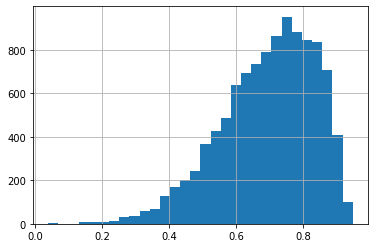

In [ ]:
compare_df.cosine_similarity.hist(bins=30)

Comparing the embeddings directly isn't the only way to measure the difference in meaning. Another way is to compare the nearest neighbors for a given word. [Hamilton et al (2016b)](https://aclanthology.org/D16-1229.pdf) call this second measure a measure of "cultural shift" (as opposed to "linguistic drift") and define it as follows:

In [ ]:
def near_neighbor_sim (embs1, embs2, query, index, k=10):
  idx, iidx = index
  nn1 = near_neighbors (embs1, query, idx, iidx, k=k)
  nn2 = near_neighbors (embs2, query, idx, iidx, k=k)

  common = {w for w, _ in nn1} | {w for w,_ in nn2}
  scores1 = np.array([embs1[idx[w]].dot (embs1[idx[query]]) for w in common])
  scores2 = np.array([embs2[idx[w]].dot (embs2[idx[query]]) for w in common])

  return np.dot (scores1, scores2)/(np.linalg.norm (scores1) * np.linalg.norm (scores2))

In [ ]:
political_words_sims = [(w, near_neighbor_sim (dem_aligned_embs, rep_aligned_embs, w, (common_idx, common_iidx),k=10)) for w in politics_words]
for w,score in sorted (political_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

democracy 0.99120164
freedom 0.98174524
taxes 0.9791561
equality 0.96484727
democrat 0.96445477
justice 0.9580842
abortion 0.9032321
republican 0.87475365
welfare 0.8567218
immigration 0.8076502


We might also use randomization to check whether differences in meaning are statistically significant. Here's one idea for how to do that, based on reshuffling the documents in the corpus into random groups. The following procedure repeatedly and randomly exchanges the speeches between the two groups, training separate models on the randomly split data. For a given word, then, change metrics could be calculated across all models.

More sophisticated approaches to randomization exist. For instance, some papers (Kozlowski et al 2019, Nelson 2021) use bootstrapping - resampling *with* replacement - to produce confidence intervals for estimates derived from word2vec models.

In [ ]:
def randomize_and_retrain (corpus1, corpus2, num_repetitions=3):
  sents1 = [sent for sent in corpus1]
  n_sents1 = len (sents1)
  sents2 = [sent for sent in corpus2]
  n_sents2 = len (sents2)

  sents = sents1 + sents2

  all_embs1 = list ()
  all_embs2 = list ()
  all_indices = list ()
  for i in range (num_repetitions):
    sample = random.sample (sents, n_sents1+n_sents2)
    part1 = sample[0:n_sents1]
    part2 = sample[n_sents1:n_sents1+n_sents2]

    m1 = Word2Vec (part1, window=10, min_count=10, seed=42, workers=1)
    m2 = Word2Vec (part2, window=10, min_count=10, seed=42, workers=1)

    embs1, (idx1, iidx1) = w2v_to_numpy (m1)
    embs2, (idx2, iidx2) = w2v_to_numpy (m2)

    embs1, embs2, (idx, iidx) = align_matrices (embs1, embs2, idx1, idx2)
    all_embs1.append (embs1)
    all_embs2.append (embs2)
    all_indices.append ((idx, iidx))

  return all_embs1, all_embs2, all_indices

In [ ]:
all_dem_embs1, all_rep_embs1, all_indices = randomize_and_retrain (dem_corpus, rep_corpus, num_repetitions=3)

This is a computationally expensive procedure because each time we have to retrain and re-align the models. To have enough placebo models to calculate p-values, we might need to do up to $100$ repetitions.

Here's the cosine similarity metric for one of the most distinct words in the actual data, recalculated on the randomly split data:

In [ ]:
w = 'welfare'
for i, _ in enumerate(all_indices):
  e1 = all_dem_embs1[i]
  e2 = all_rep_embs1[i]
  ix = all_indices[i]
  print(e1[ix[0][w]].dot(e2[ix[0][w]]))

0.72181785
0.7336098
0.74528486


## IV. Exploring substantive questions

Now, use the rest of the metadata to divide up the CR corpus in different ways.

**Try it out**: Explore diachronic semantic change, _i.e., what words have changed in meaning over time. You can do this by splitting the corpus by Congressional session, to see how Congressional language changes from 2009 (the 111th session) to 2017 (the 114th session).

First, load the metadata for the sample of speeches:

In [ ]:
cr_meta = pd.read_csv('https://raw.githubusercontent.com/sandeepsoni/comparing-word2vec-models/main/data/cr_subset_metadata.csv')
cr_meta.head()

,gender,party,state,chamber,nonvoting,session_id
0,F,D,NY,H,voting,111
1,M,D,VT,S,voting,111
2,M,D,OR,H,voting,111
3,M,D,CA,H,voting,111
4,F,D,MO,S,voting,111


Then, join the speeches corpus:

Split the corpus four ways and fit four separate models:

Extract the vectors and align each model to the first time period:

Explore the degree to which the 10 `politics_words` change over time:

**Try it out**: Test the following hypothesis:

_Congressional speech around specific issues are becoming increasingly polarized over the years_.  

This can be tested by training two models per session, aligning them, and then  measuring the difference in meaning for a set of words such as the political words that we have in this notebook. A measure of drift could be the average cosine distance between the words (or some other distance measure) which can serve as a proxy for polarization. The metric can be calculated for every session separately and aggregated to obtain a timeseries of polarization which could at least give some visual verification for the hypothesis.

To test the hypothesis more rigorously, one could modify the randomization procedure to exchange speeches across time repeatedly to learn a distribution of timeseries under a null model. Then the observed values in the timeseries can be compared to this distribution to test for statistical significance.

Further resources:

- Interested in other _word2vec_ style models: Read about [GloVe](https://nlp.stanford.edu/projects/glove/) and [fastText](https://fasttext.cc/), two popular alternatives.
- A more thorough analysis of the sensitivity of parameters to the quality of the embeddings can be found [here](https://aclanthology.org/Q18-1008.pdf) and [here](https://arxiv.org/pdf/1804.09692.pdf)
- One bottleneck to the general recipe described in this notebook is the costly alignment procedure. Read about some of the papers that do not have to do alignment [here](http://www.cs.cmu.edu/~nasmith/papers/bamman+dyer+smith.acl14.pdf), [here](https://arxiv.org/pdf/1906.01688.pdf), and [here](https://aclanthology.org/2020.acl-main.51.pdf).
- A hot application area where comparing embeddings model is necessary is in tracking language changes over time. Read more about this topic [here](https://arxiv.org/pdf/1811.06278.pdf). Some of the methods described in this notebook form  the basis of papers such as [this](https://arxiv.org/pdf/1909.04189.pdf), [this](https://arxiv.org/pdf/2103.07538.pdf), [this](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf), and [this](https://journals.sagepub.com/eprint/BBJ88DCISJPBZUYPUAU4/full).
- As much as word2vec, and the static embeddings they produce, useful and still actively researched, the more contemporary methods in NLP are based on contextual language models which map a word to multiple vectors instead of one vector dependent on the context in which the word appears in. You'll learn more about it in a subsequent tutorial but [here](https://arxiv.org/pdf/1902.06006.pdf) is a simple introduction to contextual embeddings. [Here](https://arxiv.org/pdf/2004.14118.pdf) is a paper based on contextual embeddings to identify changes in language.   

## Supplemental material: training the model on the full CR data set

We won't cover this material during the tutorial for time and logistical constraints, but you can try it on your own later.

We've hosted the full dataset for the _Congressional Record_ for the 111-114th Congresses on [Google Drive here](https://drive.google.com/drive/folders/1cbOUBJ53kEwhrXOISBQNwpEC50PC22WJ?usp=sharing). The main text file is approximately 400MB.

Intuitively, more data ought to produce better representations of word meaning. To find out whether a larger data set produces a more meaningful word2vec model, you can copy the folder over to your own Google Drive (if you have the space for it!) and train a model on it.

Examine the nearest neighbors for the keywords from the tutorial and compare the face validity to your previous models. (Rodriguez and Spirling 2021 propose a more formal human-based test for intrinsic validity. Extrinsic metrics like analogy tasks are common in the CS/NLP literature, but their usefulness for social-scientific questions isn't as clear.)

To load a data set this large into Colab, you'll need to mount your Drive as follows. The model will take several minutes to train.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/My\ Drive/word2vec_tutorial_data

cr_111-114.txt


In [ ]:
full_corpus = LineSentence('/content/drive/My Drive/word2vec_tutorial_data/cr_111-114.txt')

In [ ]:
full_model = Word2Vec(full_corpus)

In [ ]:
full_model.total_train_time

591.7294504189995

In [ ]:
for word in politics_words:
  print(word + ": " + str(full_model.wv.most_similar(word, topn=5)))

freedom: [('liberty', 0.8520753979682922), ('freedoms', 0.7836979627609253), ('democracy', 0.6669175624847412), ('selfgovernment', 0.6083847284317017), ('blessings', 0.6081134676933289)]
justice: [('antonin', 0.6525830030441284), ('justicethe', 0.642440676689148), ('justiceand', 0.6111997961997986), ('justices', 0.5589073896408081), ('justicethat', 0.5473117828369141)]
equality: [('equal', 0.6429880261421204), ('liberty', 0.5993154048919678), ('freedom', 0.5991718769073486), ('racial', 0.5757337808609009), ('tolerance', 0.5734748840332031)]
democracy: [('selfgovernment', 0.7812619209289551), ('liberty', 0.6720027923583984), ('freedom', 0.666917622089386), ('pluralistic', 0.6564258933067322), ('pluralism', 0.6238898038864136)]
abortion: [('abortions', 0.8474483489990234), ('contraception', 0.7411530017852783), ('contraceptives', 0.7077350616455078), ('sterilization', 0.6809824705123901), ('sterilizations', 0.6785510182380676)]
immigration: [('tort', 0.576901912689209), ('sentencing', 0.

In [ ]:
for word in politics_words:
  print(word + ": " + str(model.wv.most_similar(word, topn=5)))

freedom: [('liberty', 0.8142341375350952), ('conscience', 0.8119156360626221), ('liberties', 0.7927228212356567), ('religious', 0.7802432775497437), ('civil', 0.7660068273544312)]
justice: [('criminal', 0.6601111888885498), ('scalia', 0.63294517993927), ('uphold', 0.6007159948348999), ('kagan', 0.5907998085021973), ('counsel', 0.5896000862121582)]
equality: [('peace', 0.8181419968605042), ('solemn', 0.8179757595062256), ('beacon', 0.8173268437385559), ('sacred', 0.8134492039680481), ('enduring', 0.8034995794296265)]
democracy: [('values', 0.7751235365867615), ('israel', 0.7256131172180176), ('republic', 0.7079468965530396), ('nation', 0.7061699628829956), ('allies', 0.7045486569404602)]
abortion: [('parenthood', 0.7673788070678711), ('treatment', 0.7597946524620056), ('healthcare', 0.7593953013420105), ('planned', 0.7538892030715942), ('provider', 0.7461418509483337)]
immigration: [('reform', 0.8119494915008545), ('broken', 0.801181435585022), ('comprehensive', 0.7987378835678101), ('c

In [ ]:
# the smaller model was much faster to train!
model.total_train_time

12.869292167999959

In [ ]:
dem_full_model = Word2Vec(LineSentence('/content/drive/My Drive/word2vec_tutorial_data/cr_dem.txt'))

In [ ]:
rep_full_model = Word2Vec(LineSentence('/content/drive/My Drive/word2vec_tutorial_data/cr_rep.txt'))

In [ ]:
for word in politics_words:
  print(word + ": " + str(dem_full_model.wv.most_similar(word, topn=5)))
for word in politics_words:
  print(word + ": " + str(rep_full_model.wv.most_similar(word, topn=5)))

freedom: [('liberty', 0.7604895234107971), ('freedoms', 0.726006805896759), ('expression', 0.6652768850326538), ('equality', 0.6386710405349731), ('free', 0.611534595489502)]
justice: [('labors', 0.5449870824813843), ('antonin', 0.5447324514389038), ('justices', 0.5230984091758728), ('transportations', 0.4961283802986145), ('defense', 0.46832096576690674)]
equality: [('equal', 0.6622339487075806), ('liberty', 0.6565925478935242), ('freedom', 0.6386710405349731), ('tolerance', 0.5838267207145691), ('ideals', 0.5804051160812378)]
democracy: [('liberty', 0.6540989875793457), ('citizenry', 0.6339601278305054), ('expression', 0.6326954364776611), ('society', 0.6189396381378174), ('freedoms', 0.6137824058532715)]
abortion: [('abortions', 0.8089573383331299), ('contraception', 0.7032475471496582), ('contraceptives', 0.6047090291976929), ('contraceptive', 0.5925676226615906), ('parenthood', 0.5815621614456177)]
immigration: [('tort', 0.561780571937561), ('tsca', 0.5492129921913147), ('judaism'